In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam import interactions
from beam.beams import electronbeam
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from ionization import adk
plt.style.use('notes')

path = '/media/robert/Data_Storage/Data/Optics_Beam/Spherical_Lens_Plasma/'
loadPath = '/media/robert/Data_Storage/Data/Ionization/SphericalAndRamp/SecondAttempt_Sweeps/'
lam = 0.8
tau = 35.

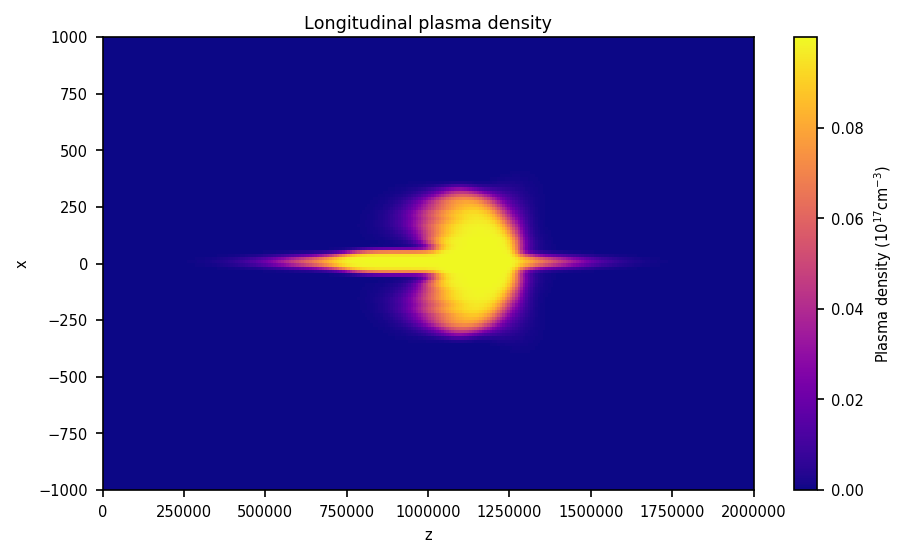

In [2]:
# Load some of the plasmas we created earlier and test beam propagation through them. 
name = 'E0-150_waist-150_SPlasma'
plasmaParams = np.load(loadPath+'elements/element_'+name+'/'+name+'_params.npy').item()
plasmaParams['load'] = True
argon = plasma.Plasma(plasmaParams)
argon.plot_long_density_center(lim=[-1000, 1000])
argon.dgammadz = lambda ne: 0.0 # For now set energy gain to zero
# Create the electron beam
beta = 0.10   # Waist beta function in (m)
gamma = 20000 # Beam relativistic Lorentz factor
electronParams = {
    'path' : path,
    'load' : False,
    'N' : 10000,
    'gamma' : gamma,
    'emittance' : 7e-6,
    'sigmaz' : 5e-6,
    'dE' : 0.01
}
# Create the beam propagation grid
Nz = 4000
Z = plasmaParams['Z']
zsim = np.linspace(0, Z, Nz)
# Handle the dump periodicity
dumpPer = 4
m = int(Nz/dumpPer)
beam_z = np.linspace(0.0, Z, m)
dz = Z/(m-1)
beam_ne = argon.get_ne(beam_z)

In [3]:
# Coarse study to find the waist location for which the emittance is minimized.
W = 10
waist = np.linspace(0.0, 0.75, W) # Vacuum waist position from start of simulation (m)
for i in range(W):
    betaBeam = beta+(waist[i])**2/beta
    alphaBeam = waist[i]/beta
    electronParams['betax'] = betaBeam,
    electronParams['betay'] = betaBeam,
    electronParams['alphax'] = alphaBeam,
    electronParams['alphay'] = alphaBeam,
    electronParams['name'] = 'Waist-%0.3f' % waist[i]
    beam = electronbeam.GaussianElectronBeam(electronParams)
    interactions.electron_plasma(beam, argon, zsim, dumpPer, 4)
    en = np.average(beam.get_emittance_n(m-1))*1e6
    print('Waist: %0.3f, Final Emittance: %0.2f' %(waist[i], en))

Waist: 0.000, Final Emittance: 17.58
Waist: 0.083, Final Emittance: 12.16
Waist: 0.167, Final Emittance: 8.78
Waist: 0.250, Final Emittance: 7.41
Waist: 0.333, Final Emittance: 7.11
Waist: 0.417, Final Emittance: 7.97
Waist: 0.500, Final Emittance: 10.26
Waist: 0.583, Final Emittance: 14.25
Waist: 0.667, Final Emittance: 20.51
Waist: 0.750, Final Emittance: 28.45


In [4]:
# Now that we know about where the emittance is minimized, run a detailed study
W = 20
waist = np.linspace(0.25, 0.42, W) # Vacuum waist position from start of simulation (m)
en = np.zeros(W, dtype='double')
eni = np.zeros(W, dtype='double')
for i in range(W):
    betaBeam = beta+(waist[i])**2/beta
    alphaBeam = waist[i]/beta
    electronParams['betax'] = betaBeam,
    electronParams['betay'] = betaBeam,
    electronParams['alphax'] = alphaBeam,
    electronParams['alphay'] = alphaBeam,
    electronParams['name'] = 'Waist-%0.3f' % waist[i]
    beam = electronbeam.GaussianElectronBeam(electronParams)
    interactions.electron_plasma(beam, argon, zsim, dumpPer, 4)
    en[i] = np.average(beam.get_emittance_n(m-1))*1e6
    eni[i] = np.average(beam.get_emittance_n(0))*1e6

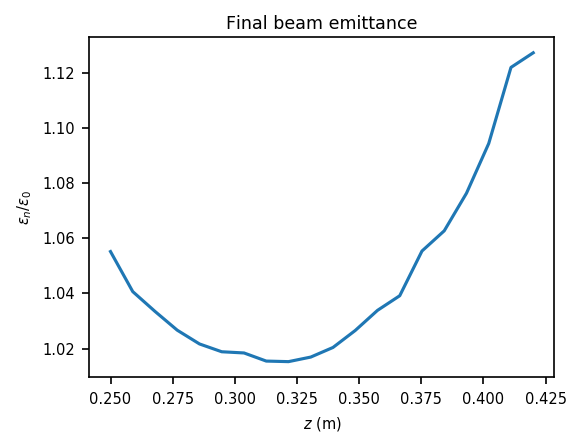

In [5]:
plt.figure(figsize=(4, 3), dpi=150)
plt.plot(waist, en/eni)
plt.title('Final beam emittance')
plt.xlabel(r'$z^*$ (m)')
plt.ylabel(r'$\epsilon_n/\epsilon_0$')
plt.show()

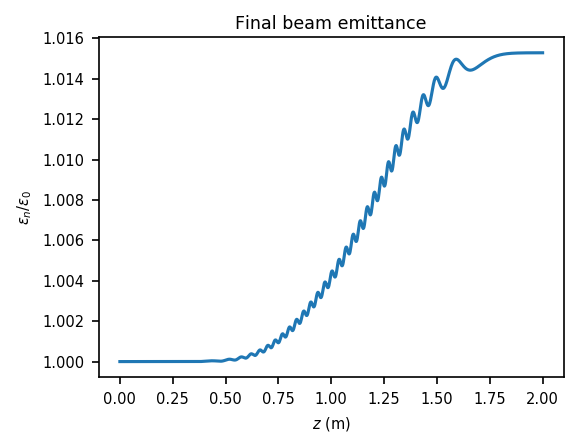

In [11]:
name = 'Waist-0.322'
beamParams = np.load(path+'beams/beam_'+name+'/'+name+'_params.npy').item()
beamParams['load'] = True
beam = electronbeam.GaussianElectronBeam(beamParams)

en = np.empty(m, dtype='double')
eni = np.average(beam.get_emittance_n(0))*1e6
for i in range(m):
    en[i] = np.average(beam.get_emittance_n(i))*1e6
    
plt.figure(figsize=(4, 3), dpi=150)
plt.plot(beam_z/1e6, en/eni)
plt.title('Final beam emittance')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\epsilon_n/\epsilon_0$')
plt.show()   